we have a churn modelling dataset(as we can solve classification or regression problem with help of ANN) based on given dataset we need to tell whether a person will exit the bank or not sort of binary classification

on the dataset we perform basic feature engineering like convert categorical variables into numericals, standardization etc then get a numerical data and then give all feature to ANN input nodes then create required hidden layer and output and connect them all also apply dropout(drop random neuron in middle layer to avoid overfitting) we train it use loss and optimizer using keras.tensorflow
then convert this model into a pickle file so use this model for deployment 
then use streamlit to create webapp and deploy it in streamlit cloud

In [3]:
#create a requiremnets.txt file with all library required in this project
# then install it by writing "pip install -r requirements.txt" in terminal
#select new created envirement

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import pickle # to reuse the model or steps to use during deployment

In [5]:
## load the dataset
data=pd.read_csv("Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# on the given info we try to predict whether a person will exit the bank or not
# and from above table we can see first 3 rows are not that important as they provide info
# which are not useful RowNumber,	CustomerId,	Surname drop them
# Preprocess the data
# drop irrelevant features
data=data.drop(['RowNumber','CustomerId','Surname'],axis=1) # axis=1 means column wise
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
#here geography and gender are categorical features so we can apply some sort of encoding
# to convert them in numerical and use them
## Encode categorical variables since only two values like male and female so we use level encoder
label_encoder_gender=LabelEncoder() # initialise label encode
data['Gender']=label_encoder_gender.fit_transform(data['Gender'])
data # our gender has 2 values male and female with label encode it get converted to 0 and 1

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [8]:
# for geography column has more than 2 different values 
# and here we cannot use label encoder here if we used it it will have values like
# France=1, spain=1, germany=2 and etc and when ANN see germany =2 it will treat it above 
# france and spain so will result in bias model
# so here we use one hot encoding
## onehot encode 'Geography'
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder_geo=OneHotEncoder()
geo_encoded=one_hot_encoder_geo.fit_transform(data[['Geography']])
geo_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10000 stored elements and shape (10000, 3)>

In [9]:
#convert it into array to manipulate it further
geo_encoded_arr=geo_encoded.toarray()
geo_encoded_arr

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [10]:
#see all feature with respect to geography
one_hot_encoder_geo.get_feature_names_out(['Geography']) # these 3 convert to sparse matrix

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [12]:
#convert sparse matrix into a dataframe so we can combine it with our data and assign column as the features it had 
geo_encoded_df=pd.DataFrame(geo_encoded_arr,columns=one_hot_encoder_geo.get_feature_names_out(['Geography']))
geo_encoded_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [13]:
# combine all together onehot encoded and our original data set and drop previous geograpgy column
data=pd.concat([data.drop('Geography',axis=1),geo_encoded_df],axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [39]:
#save encoder and scalar in pickle so can directly use it again
with open('label_encoder_gender.pkl','wb') as file: #we open in wb mode since its a serialize file
    pickle.dump(label_encoder_gender,file)

with open('onehot_encoder_geo.pkl','wb') as file: #we open in wb mode since its a serialize file
    pickle.dump(one_hot_encoder_geo,file)

In [14]:
## divide dataset in independent(x)(all columns except exit) and dependent(y)(exit column) feature
X=data.drop('Exited',axis=1)
Y=data['Exited']



In [15]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


In [16]:
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [17]:

## Split the data in training and tetsing sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

## Scale these features so all features comes down to a comman scale
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [40]:
# also save pickle of this scalar data
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

In [18]:
# now my data is ready we will train our ANN on this data
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0


### ANN Implementation

In [1]:
import tensorflow as tf
# ANN in tensorflow is a sequential model like input layer, them hidden layers and then output layer 
from tensorflow.keras.models import Sequential #so import this
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

## lets take an example as shown below
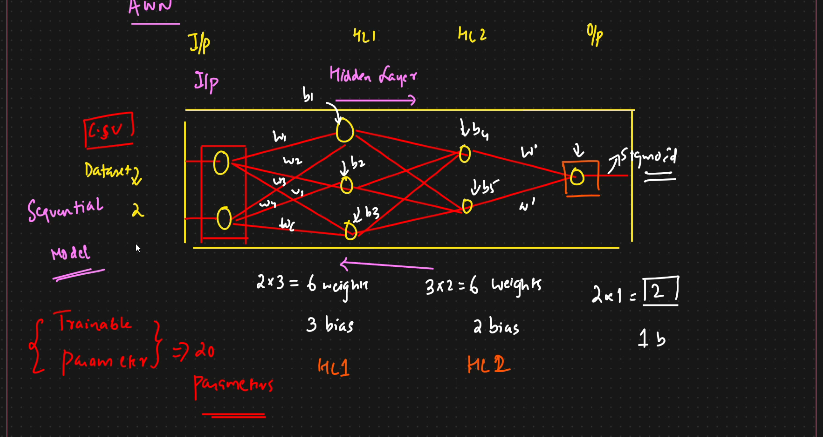

we have two input and two hidden layer 1st one has 3 neuron and 2nd has 2 and so weights for 1 hidden layer will be 6 as 2 neuron in input layer get connected to each neuron in hidden layer 1 and for each neuron in hidden layer we add bias as well so 3 bias so for hidden layer 1 we have 6 weights and 3 bias similarly for hidden layer 2 we have 6 weights and 2 bias and for output we have 2 weights and  1 bias

so total trainable parameters are 20(bias +weights)

input depends on the features in out data set x values

so ANN model
1. Sequential N/W
2. to create hidden neuron use Dense so if say dense(64) we will have 64 neuron in that layer
3. Activation function- at each node we apply this like sigmoid,tanh,relu etc
4. optimizer- useful in backpropogation for updating weight
5. loss function
6. metrics- for classification problem its accuracy and for regression it is mse,mae,r2score etc
7. store training info in logs and use tensorboard to display this logs in easy way

our input will be number of column in X_train.shape of input layer and then use dense to create hidden layer using dense we also give dense neuron the input shape coming from previous layer which will get connected to neuron in dense only for 1st hidden layer u need to give input shape and rest it will manage

In [19]:
X_train.shape[1] # give number of columns

12

In [20]:
(X_train.shape[1],) # if give , blank mean its a single dimension with 12 inputs

(12,)

In [23]:
# Build ANN model
model = Sequential([
  Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # 1st hidden layer connected with input layer
  Dense(32, activation='relu'),  # 2nd hidden layer
  Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

so like in our example we say 20 trainable parameters here for our dataset we will have 2945 trainable parameters

In [27]:
import tensorflow
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.01) ## optimizer


In [28]:
#now to do forward and backward propogation we need to compile this model
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=['accuracy'])

In [29]:
## set up the tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # create this directory to capture logs in this datetime format
tensorflow_callback=TensorBoard(log_dir=log_dir,histogram_freq=1) # use this visulize logs while training it guve it the log directory and histogram freq  

In [32]:
## Set up Early Stopping, as we can train neural number to any number of epochs
# but it may get saturated sometimes before even completing the entire epochs so we can 
# stop it, i.e if after a certain point the loss value is not decreasing and remaining constant we can stop the training
# so we early_stopping for that only, here we check loss for 20 epochs like if val_loss remains constant for 10 epochs stop it
# and restore the best weights
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)


In [33]:
## Training the model
history=model.fit(
    X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,
    callbacks=[tensorflow_callback,early_stopping_callback]
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8671 - loss: 0.3194 - val_accuracy: 0.8600 - val_loss: 0.3486
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3162 - val_accuracy: 0.8600 - val_loss: 0.3441
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8684 - loss: 0.3167 - val_accuracy: 0.8605 - val_loss: 0.3571
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3071 - val_accuracy: 0.8635 - val_loss: 0.3471
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.3158 - val_accuracy: 0.8600 - val_loss: 0.3506
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3135 - val_accuracy: 0.8610 - val_loss: 0.3600
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3086 - val_accuracy: 0.8635 - val_loss: 0.3613
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.2868 - val_accu

In [34]:
#lets save this trained model
model.save('model.h5')

In [35]:
# lets b load tensorboard extension
%load_ext tensorboard

In [37]:
#now take this tensorboard and use the log directory 
# inside it we have logs/fits folder and will show us visulaization of all
# click on launch tensorboard and select the train folder and see the entire analysis
%tensorboard --logdir logs/fit/20240818-145451